# 로지스틱 회귀

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


## #02. 데이터 준비
방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라.

단, 독립변수는 정규분포를 따른다고 가정한다.

In [3]:
origin = pd.read_excel('https://data.hossam.kr/E05/gradeuate.xlsx')
origin.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## #03. 데이터 전처리

### 결측치 확인

In [6]:
origin.isnull().sum()

합격여부    0
필기점수    0
학부성적    0
병원경력    0
dtype: int64

### 명목형 변수에 대한 데이터 타입 설정

In [7]:
origin['합격여부'] = origin['합격여부'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   합격여부    400 non-null    category
 1   필기점수    400 non-null    int64   
 2   학부성적    400 non-null    float64 
 3   병원경력    400 non-null    int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 10.0 KB


## #04. 탐색적 데이터 분석

In [8]:
origin.describe()

,필기점수,학부성적,병원경력
count,400.000000,400.000000,400.00000
mean,587.700000,3.389900,2.48500
std,115.516536,0.380567,0.94446
min,220.000000,2.260000,1.00000
25%,520.000000,3.130000,2.00000
50%,580.000000,3.395000,2.00000
75%,660.000000,3.670000,3.00000
max,800.000000,4.000000,4.00000


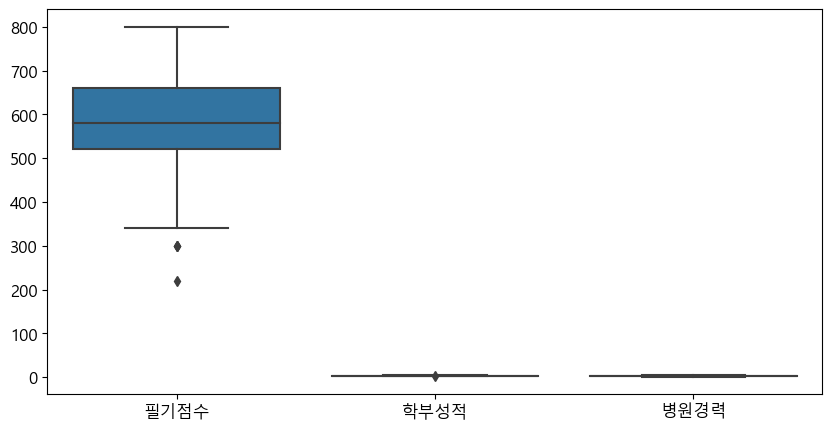

In [13]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
sns.boxplot(data=origin)
plt.show()
plt.close()

## #05. 데이터 셋 분할하기

In [14]:
np.random.seed(777)

### 종속 - 독립 분할

In [16]:
x=origin[['필기점수','학부성적','병원경력']]
y=origin[['합격여부']]

x.shape,y.shape

((400, 3), (400, 1))

### 데이터 표준화

In [18]:
.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [17]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x),columns=x.columns)
x.head()

,필기점수,학부성적,병원경력
0,-1.800263,0.579072,0.545968
1,0.626668,0.736929,0.545968
2,1.840134,1.605143,-1.574296
3,0.453316,-0.525927,1.606100
4,-0.586797,-1.209974,1.606100


### 표준화 전 후 상자그림 비교

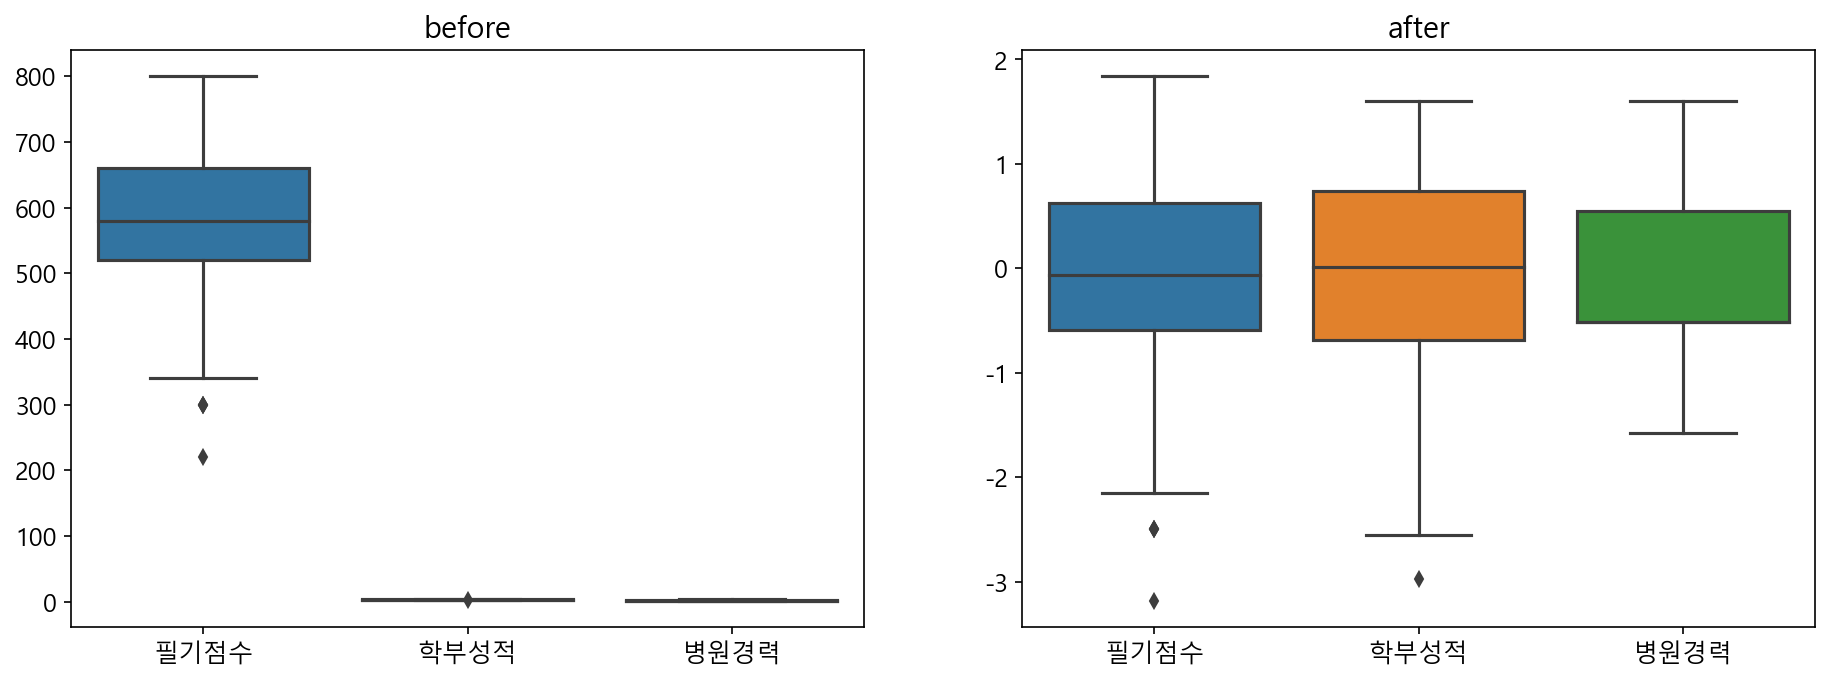

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi=150)

sns.boxplot(data=origin.iloc[:,1:],ax=ax[0])
sns.boxplot(data=x,ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 - 검증 분할


In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2131)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((280, 3), (120, 3), (280, 1), (120, 1))

## #06. 모델개발

### 모델정의

In [30]:
y_train.head()

,합격여부
70,0
76,0
358,1
380,0
250,0


In [28]:
model = Sequential()
model.add(Dense(3,activation = 'relu',input_shape=(3,)))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 3)                 12        
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [31]:
result = model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),
callbacks= [
    EarlyStopping(monitor='val_loss',patience=5,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5,min_lr=0.0001)
])

Epoch 1/500


9/9 [==============================] - 4s 188ms/step - loss: 0.6130 - acc: 0.6643 - val_loss: 0.6121 - val_acc: 0.7167 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 0s 58ms/step - loss: 0.6115 - acc: 0.6679 - val_loss: 0.6113 - val_acc: 0.7083 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 49ms/step - loss: 0.6105 - acc: 0.6643 - val_loss: 0.6104 - val_acc: 0.7000 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 52ms/step - loss: 0.6097 - acc: 0.6643 - val_loss: 0.6096 - val_acc: 0.6917 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 50ms/step - loss: 0.6089 - acc: 0.6679 - val_loss: 0.6090 - val_acc: 0.6917 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 30ms/step - loss: 0.6083 - acc: 0.6750 - val_loss: 0.6084 - val_acc: 0.6917 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 58ms/step - loss: 0.6076 - acc: 0.6750 - val_loss: 0.6078 - val_acc: 0.7000 - lr: 0.0010
Epoch 8/50

## #07. 학습결과 평가


In [35]:
result.history

{'loss': [0.6130396723747253,
  0.6115481853485107,
  0.6104539632797241,
  0.6097015142440796,
  0.6089153289794922,
  0.608286440372467,
  0.6076129674911499,
  0.6070210337638855,
  0.6062884330749512,
  0.6057283878326416,
  0.6050515174865723,
  0.6043345928192139,
  0.6037313342094421,
  0.603146493434906,
  0.6025516390800476,
  0.6020732522010803,
  0.6016122102737427,
  0.6010183095932007,
  0.6005494594573975,
  0.6001078486442566,
  0.599681556224823,
  0.599378764629364,
  0.5989345908164978,
  0.5984790921211243,
  0.5982828140258789,
  0.5979212522506714,
  0.5976277589797974,
  0.5973256826400757,
  0.5972795486450195,
  0.5969761610031128,
  0.5967053174972534,
  0.5965098142623901,
  0.5961484909057617,
  0.5959538221359253,
  0.5957620143890381,
  0.5954692959785461,
  0.5953192710876465,
  0.5950649976730347,
  0.5948145389556885,
  0.5945236086845398,
  0.5945069789886475,
  0.5942541360855103,
  0.5940205454826355,
  0.5938526391983032,
  0.5936453342437744,
  0.59

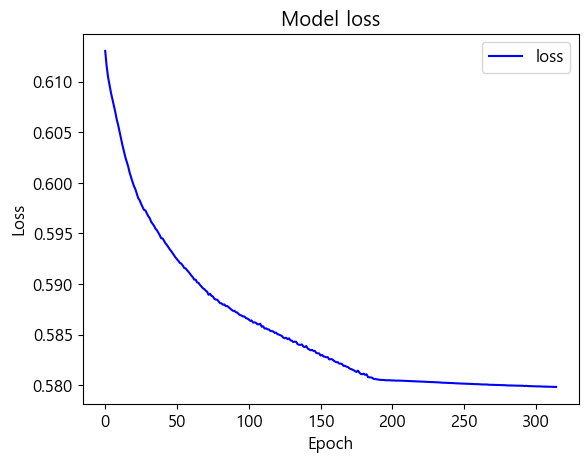

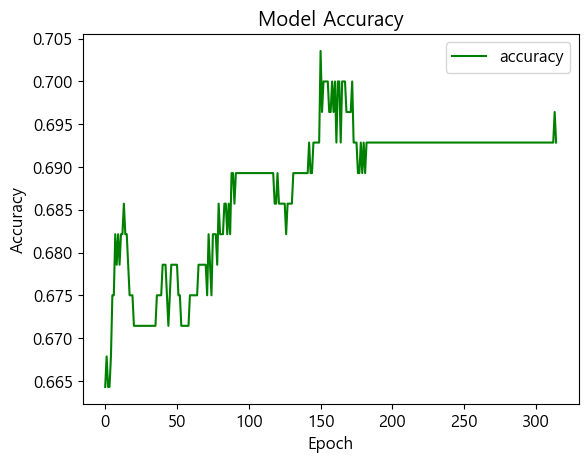

In [36]:
# 모델 손실 함수 시각화
plt.plot(result.history['loss'], 'b-', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 정확도 시각화
plt.plot(result.history['acc'], 'g-', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
# # 손실 함수 계산
# model.evaluate(x_test, y_test, batch_size=1, verbose=2)

# # 모델 시각화
# line_x = np.arange(min(x_test), max(x_test), 0.01)
# line_y = model.predict(line_x)

# plt.plot(line_x, line_y, 'r-')
# plt.plot(x_test, y_test, 'bo')
# plt.title('Model')
# plt.xlabel('test')
# plt.ylabel('predict')
# plt.legend(['predict', 'test'], loc='upper left')
# plt.show()


In [42]:
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.613040,0.664286,0.612133,0.716667,0.0010
2,0.611548,0.667857,0.611251,0.708333,0.0010
3,0.610454,0.664286,0.610449,0.700000,0.0010
4,0.609702,0.664286,0.609645,0.691667,0.0010
5,0.608915,0.667857,0.608971,0.691667,0.0010
...,...,...,...,...,...
311,0.579841,0.692857,0.568818,0.733333,0.0001
312,0.579832,0.692857,0.568820,0.733333,0.0001
313,0.579831,0.692857,0.568823,0.733333,0.0001


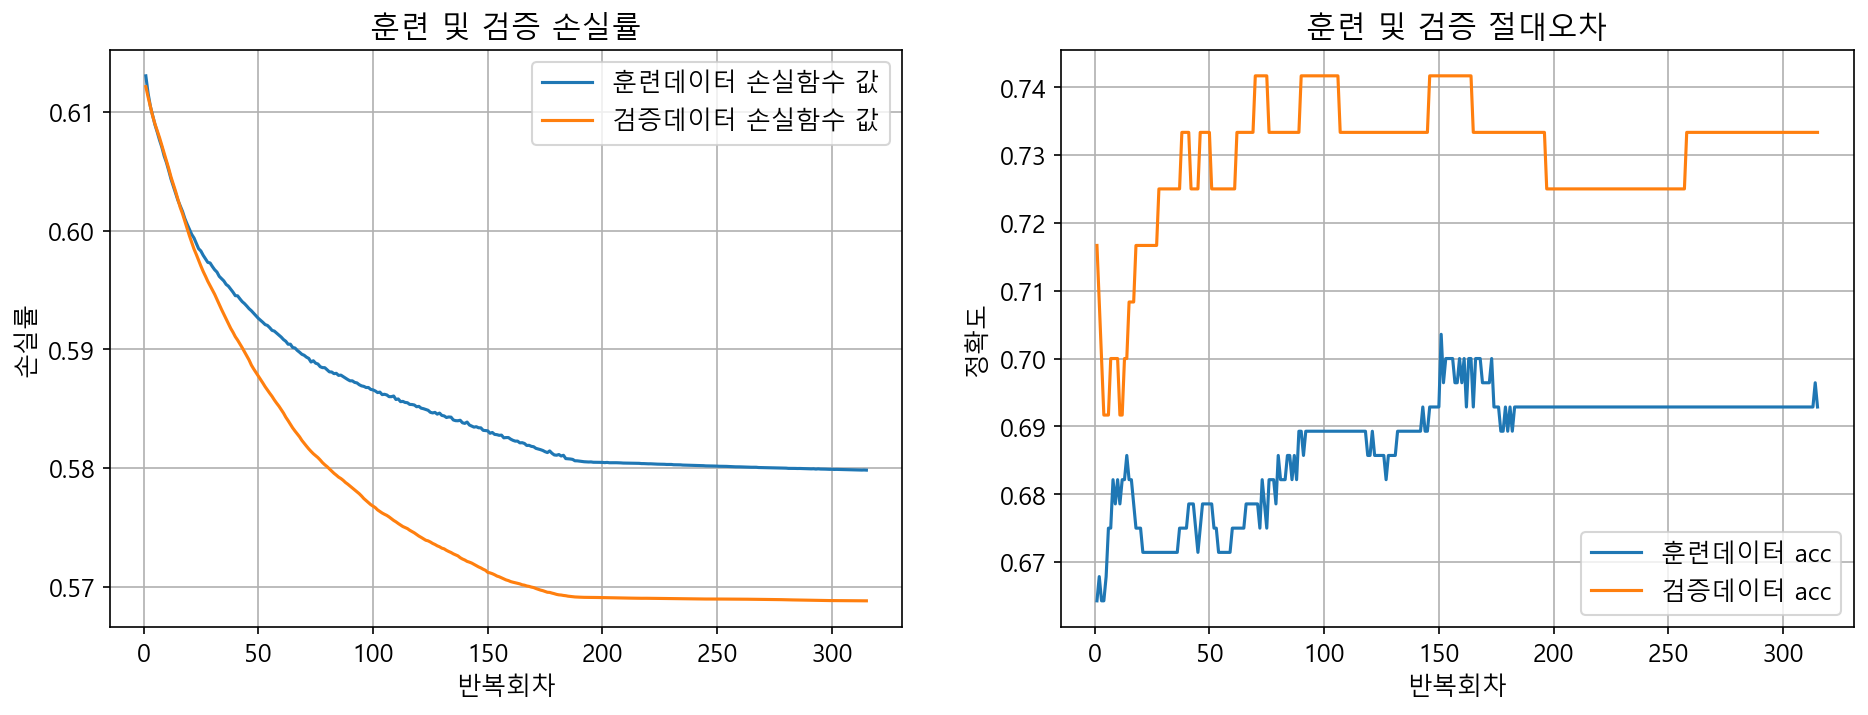

In [43]:

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='acc',data=result_df,label='훈련데이터 acc',ax=ax2)
sns.lineplot(x=result_df.index,y='val_acc',data=result_df,label='검증데이터 acc',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

## #08. 학습결과 적용

### 훈련데이터에 대한 예측결과 산정

In [44]:
train_pred = model.predict(x_train)
data_count,case_count = train_pred.shape
print("%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(train_pred)

9/9 [==============================] - 1s 4ms/step
280개의 훈련 데이터가 1개의 경우의 수를 갖는다.
[[0.2860096 ]
 [0.32007402]
 [0.27238727]
 [0.50692016]
 [0.203996  ]
 [0.18644728]
 [0.35280007]
 [0.47789   ]
 [0.2476052 ]
 [0.31014872]
 [0.39962363]
 [0.34707588]
 [0.38348502]
 [0.13589376]
 [0.48623335]
 [0.14894253]
 [0.37275672]
 [0.11566218]
 [0.07453118]
 [0.30016136]
 [0.383163  ]
 [0.25317118]
 [0.26301262]
 [0.57174534]
 [0.09710985]
 [0.39265284]
 [0.32035777]
 [0.34897274]
 [0.20583354]
 [0.23686083]
 [0.11104625]
 [0.07409436]
 [0.23879752]
 [0.46880484]
 [0.50692016]
 [0.20700713]
 [0.31163615]
 [0.40399802]
 [0.5108404 ]
 [0.24811763]
 [0.43936652]
 [0.21520971]
 [0.50369155]
 [0.5061593 ]
 [0.08922809]
 [0.5168469 ]
 [0.30878156]
 [0.2657934 ]
 [0.24985132]
 [0.18237583]
 [0.22112945]
 [0.52057785]
 [0.15260367]
 [0.23502958]
 [0.09281724]
 [0.20517236]
 [0.4606695 ]
 [0.5347059 ]
 [0.5410588 ]
 [0.54131067]
 [0.3349832 ]
 [0.48509488]
 [0.32606846]
 [0.17168978]
 [0.42885953]
 [0.28407

### 검증 데이터에 대한 예측 결과 산정

In [45]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
#print(test_pred)

4/4 [==============================] - 0s 7ms/step
120개의 검증 데이터가 1개의 경우의 수를 갖는다.


### 결과 데이터 셋 구성

array([[0.2860096 ],
       [0.32007402],
       [0.27238727],
       [0.50692016],
       [0.203996  ]], dtype=float32)

In [49]:
rdf = pd.DataFrame({
    '결과값':y_train['합격여부'].values,
    '예측치':np.round(train_pred.flatten()),
    '합격확률':np.round(train_pred.flatten()*100,1)
})
rdf.head()

,결과값,예측치,합격확률
0,0,0.0,28.600000
1,0,0.0,32.000000
2,1,0.0,27.200001
3,0,1.0,50.700001
4,0,0.0,20.400000


### 혼동 행렬

In [50]:
cm = confusion_matrix(rdf['결과값'],rdf['예측치'])
tn,fp,fn,tp = cm.ravel()
cmdf = pd.DataFrame([[tn, fn], [fp, tp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,169,66
False,19,26


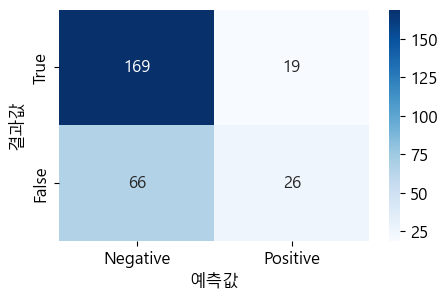

In [52]:
plt.figure(figsize=(5,3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['True', 'False'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 평가지표

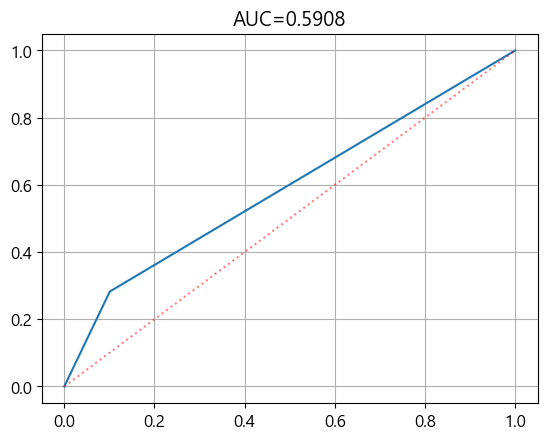

In [54]:
ras = roc_auc_score(rdf['결과값'],rdf['예측치'])

# 위양성율, 재현율, 임계값(사용안함)
fpr,tpr,threshold = roc_curve(rdf['결과값'],rdf['예측치'])
plt.figure()
sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [55]:
# 정확도
acc = accuracy_score(rdf['결과값'],rdf['예측치'])
# 정밀고
pre = precision_score(rdf['결과값'],rdf['예측치'])
#재현률
recall = recall_score(rdf['결과값'],rdf['예측치'])
# F1 점수
f1 = f1_score(rdf['결과값'],rdf['예측치'])
# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = pd.DataFrame({'정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})


In [56]:
result_df

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.696429,0.577778,0.282609,0.101064,0.898936,0.590772,0.379562


In [57]:
report = classification_report(rdf['결과값'], rdf['예측치'])
print(report)

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       188
           1       0.58      0.28      0.38        92

    accuracy                           0.70       280
   macro avg       0.65      0.59      0.59       280
weighted avg       0.67      0.70      0.66       280

